# Calcio Trends Impact Score

## Overview
Calcio Trends Impact Score is a metric that measures the impact of a player in a football match. It is calculated based on the player's performance in the match and the importance of the match. The score is calculated using a combination of various factors such as goals scored, assists, passes completed, tackles won, and other performance metrics. The score is then normalized to a scale of 0 to 100 to provide a standardized measure of a player's impact in a match.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import List
import csv

In [45]:
app = pd.read_csv("Assignment_Data/appearances.csv")
players = pd.read_csv("Assignment_Data/players.csv")

## Data preprocessing

In [46]:
@dataclass
class game:
    game_id: int
    yellow_cards: int
    red_cards: int
    goals: int
    assists: int
    date: str

@dataclass
class Player_Data:
    player_id: int
    market_value_in_eur: float
    position: str
    games: list[game]
    

In [47]:
@dataclass
class Player:
    player_id: int
    market_value_in_eur: float
    position: str

@dataclass
class Appearance:
    player_id: int
    yellow_cards: int
    red_cards: int
    goals: int
    assists: int
    date: str
    game_id: int

@dataclass
class PlayerStats:
    player_id: int
    market_value_in_eur: str
    position: str
    yellow_cards: List[int] = field(default_factory=list)
    red_cards: List[int] = field(default_factory=list)
    goals: List[int] = field(default_factory=list)
    assists: List[int] = field(default_factory=list)
    dates: List[str] = field(default_factory=list)
    game_ids: List[int] = field(default_factory=list)


In [48]:
def load_players_from_csv(file_path: str) -> List[Player]:
    players = []
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            player = Player(
                player_id=int(row['player_id']),
                market_value_in_eur=row['market_value_in_eur'],
                position=row['position']
            )
            players.append(player)
    return players

def load_appearances_from_csv(file_path: str) -> List[Appearance]:
    appearances = []
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            appearance = Appearance(
                player_id=int(row['player_id']),
                yellow_cards=int(row['yellow_cards']),
                red_cards=int(row['red_cards']),
                goals=int(row['goals']),
                assists=int(row['assists']),
                date=row['date'],
                game_id=int(row['game_id'])
            )
            appearances.append(appearance)
    return appearances

In [49]:
def filter_last_season(app: List[Appearance], filter_year: str) -> List[Appearance]:
    return [appearance for appearance in app if filter_year in appearance.date]

def merge_and_select_columns(players: List[Player], appearances: List[Appearance]) -> List[PlayerStats]:
    player_stats = []
    for player in players:
        matching_appearances = [app for app in appearances if app.player_id == player.player_id]
        if matching_appearances:
            stats = PlayerStats(
                player_id=player.player_id,
                market_value_in_eur=player.market_value_in_eur,
                position=player.position,
                yellow_cards=[app.yellow_cards for app in matching_appearances],
                red_cards=[app.red_cards for app in matching_appearances],
                goals=[app.goals for app in matching_appearances],
                assists=[app.assists for app in matching_appearances],
                dates=[app.date for app in matching_appearances],
                game_ids=[app.game_id for app in matching_appearances]
            )
            player_stats.append(stats)
    return player_stats

def group_by_player(player_stats: List[PlayerStats]) -> List[PlayerStats]:
    # Grouping is inherently handled by the merge_and_select_columns function in this approach
    return player_stats

def filter(filter_year: str, players: List[Player], app: List[Appearance]) -> List[PlayerStats]:
    appearances_last_season = filter_last_season(app, filter_year)
    merged_data = merge_and_select_columns(players, appearances_last_season)
    grouped_data = group_by_player(merged_data)
    return grouped_data

# Evaluation Function

We've decided to base the Impact of a player on a game on his general performance in the game. We've decided to use the following metrics to evaluate the performance of a player in a game:
- Goals Scored
- Assists
- Yellow Cards
- Red Cards

We are aware of the bias towards attacking players, but due to the nature of the data, we are unable to include other metrics such as tackles, interceptions, etc. We will be using the following function to evaluate the performance of a player in a game:

In [51]:
def calculate_score(player_stats: PlayerStats) -> float:
    """
    Calculate the score for a player based on the given formula.
    
    Parameters:
    player_stats (PlayerStats): An instance of PlayerStats containing player and their appearances.
    
    Returns:
    float: The calculated score for the player.
    """
    score = 1
    
    for i in range(len(player_stats.game_ids)):
        position_coefficient = 1 + ((player_stats.position in ['attack', 'midfield']) * 0.2)
        assist_score = player_stats.assists[i] * 0.45
        goal_score = player_stats.goals[i] * position_coefficient
        yellow_card_score = player_stats.yellow_cards[i] * -0.2
        if player_stats.position == 'defense':
            yellow_card_score *= -1
        red_card_score = player_stats.red_cards[i] * -0.5
        
        game_score = goal_score + yellow_card_score + red_card_score + assist_score
        score += game_score
        
    return score/len(player_stats.game_ids)

## Example usage

In [52]:

player_data_example = (
    'player1',             # player_id
    'attack',              # position
    [1, 0, 2],             # yellow_cards list
    [1, 0, 0],             # red_cards list
    [0, 2, 0],             # goals list
    [3, 1, 4],             # assists list
    ['game1', 'game2', 'game3'],  # game_ids list
    80000000               # market_value_in_eur
)

# Calculate score for the example player data
score = calculate_score(player_data_example)

print(f"The calculated score is: {score}")

The calculated score is: 5.9


## Normalization

The Impact Score will be normalized to a scale of 0 to 100 to provide a standardized measure of a player's impact in a match.

In [53]:
def normalize_scores(scores):
    """
    Normalize the scores to be between 1 and 10.
    
    Parameters:
    scores (list): A list of scores for all players.
    
    Returns:
    list: A list of normalized scores between 1 and 100.
    """
    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [1 + (score - min_score) * (100 - 1) / (max_score - min_score) for score in scores]
    return normalized_scores

## Example usage

In [54]:
players_data = [
    ('player1', 'attack', [1, 0, 0], [0, 1, 0], [2, 1, 3], [1, 1, 1], ['game1', 'game2', 'game3']),
    ('player2', 'midfield', [0, 0, 1], [0, 0, 0], [1, 2, 1], [2, 2, 2], ['game1', 'game2', 'game3']),
    ('player3', 'defense', [0, 1, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], ['game1', 'game2', 'game3']),
    # Add more player data as needed
]

# Calculate scores for all players
scores = [calculate_score(player_data) for player_data in players_data]

# Normalize the scores
normalized_scores = normalize_scores(scores)

# Display the normalized scores
for player_data, score, normalized_score in zip(players_data, scores, normalized_scores):
    print(f"Player: {player_data[0]}, Original Score: {score}, Normalized Score: {normalized_score}")


Player: player1, Original Score: 8.85, Normalized Score: 100.0
Player: player2, Original Score: 8.3, Normalized Score: 93.31901840490798
Player: player3, Original Score: 0.7, Normalized Score: 1.0


## Data Analysis

The calculated scores have been appended to the players database through the use of an [append](append.py) script, for simplicity going forward we will be using the appended database. 

In [70]:
# Read the CSV file
scores_df = pd.read_csv("Assignment_Data/updated_players.csv")

# Filter out rows where the score is -1
filtered_df = scores_df[scores_df['score'] != -1]

## Plot 1: Histogram of Scores

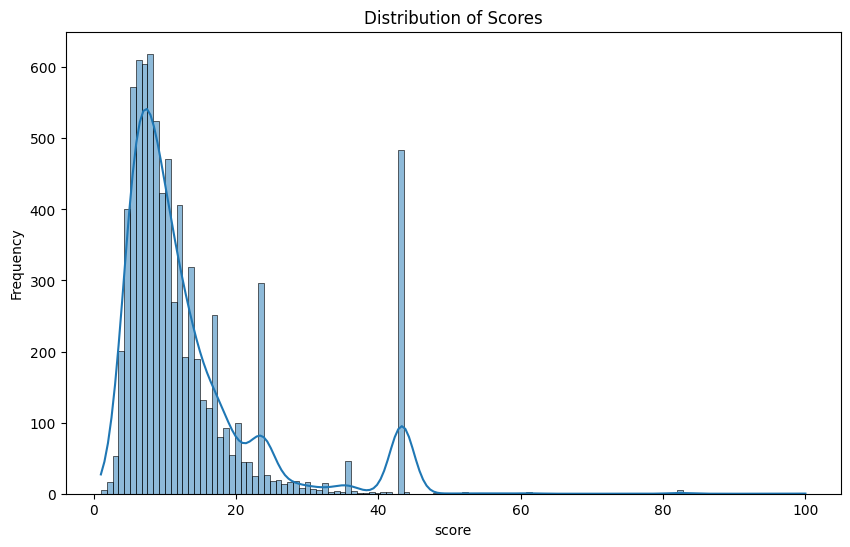

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['score'], kde=True)
plt.title('Distribution of Scores')
plt.xlabel('score')
plt.ylabel('Frequency')
plt.show()

## Plot 2: Scatter Plot of score vs. Age

/tmp/ipykernel_7039/2669487706.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date_of_birth'] = pd.to_datetime(filtered_df['date_of_birth'])
/tmp/ipykernel_7039/2669487706.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Age'] = current_year - filtered_df['date_of_birth'].dt.year


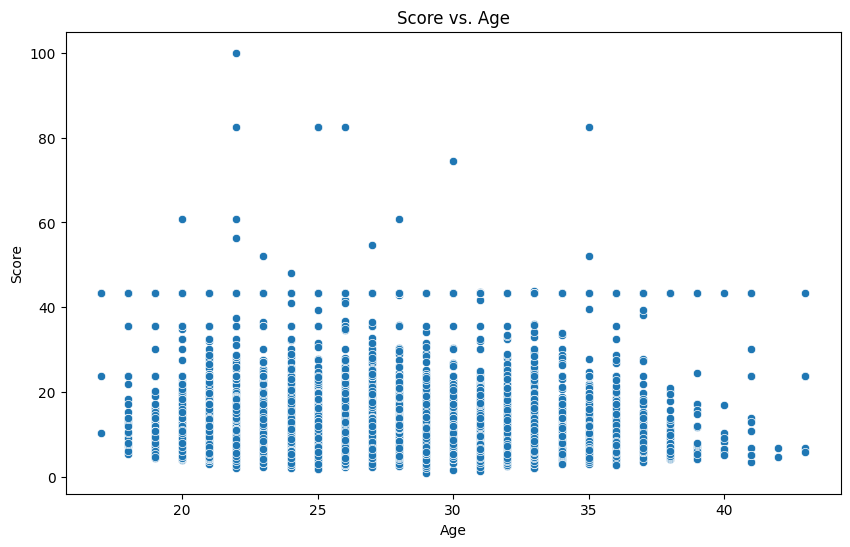

In [73]:
from datetime import datetime

# Assuming 'dob' is the column in 'filtered_df' that contains the day of birth
# Convert 'dob' to datetime format if it's not already
filtered_df['date_of_birth'] = pd.to_datetime(filtered_df['date_of_birth'])

# Calculate age in years and create a new column 'Age'
current_year = datetime.now().year
filtered_df['Age'] = current_year - filtered_df['date_of_birth'].dt.year

# Now plot using the new 'Age' column
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='score', data=filtered_df)
plt.title('Score vs. Age')
plt.xlabel('Age')
plt.ylabel('Score')
plt.show()

## Plot 3: Count Plot of Roles

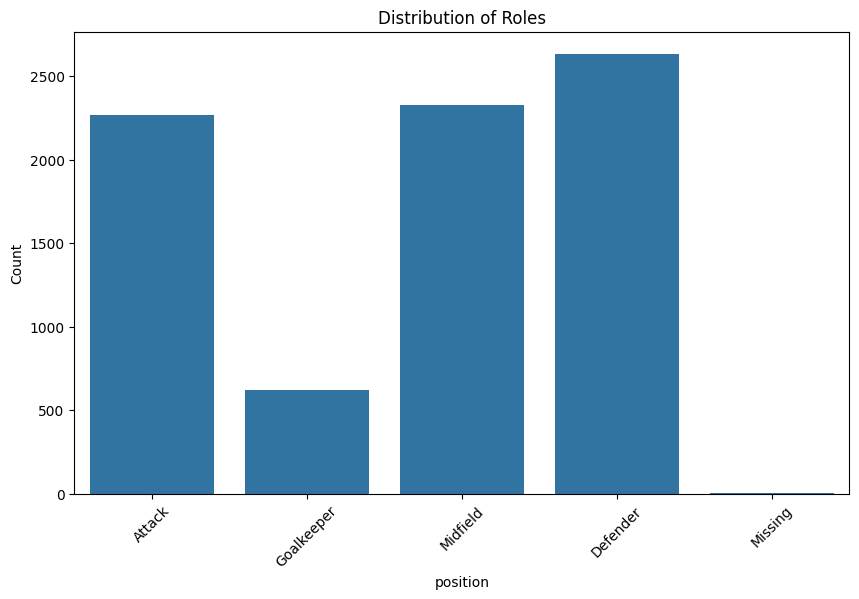

In [74]:
plt.figure(figsize=(10, 6))
sns.countplot(x='position', data=filtered_df)
plt.title('Distribution of Roles')
plt.xlabel('position')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Plot 4: Scores by position

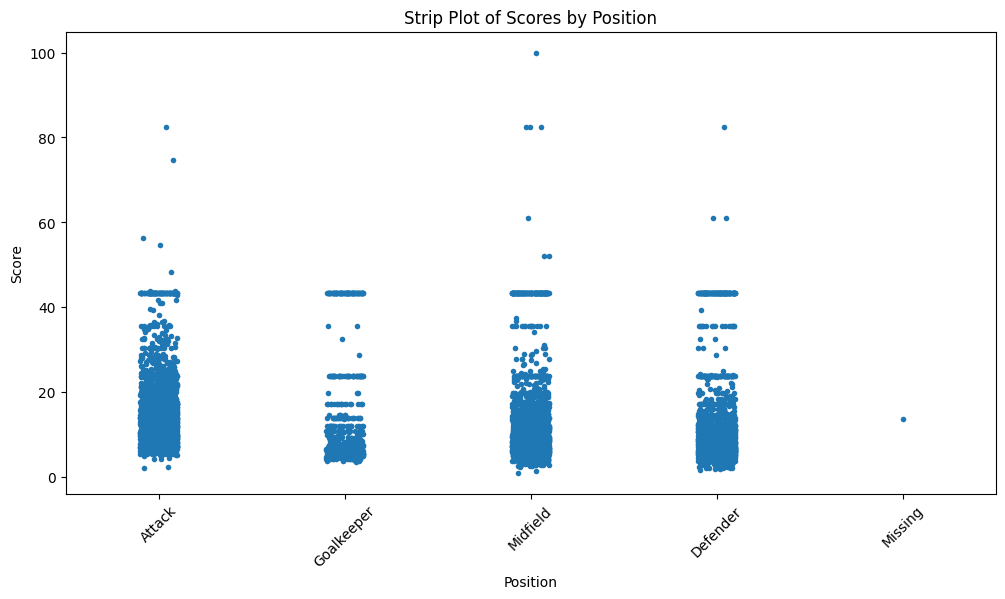

In [78]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='position', y='score', data=filtered_df, size=4, jitter=True)  # Use strip plot with jitter
plt.title('Strip Plot of Scores by Position')
plt.xlabel('Position')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()